In [1]:
# Dependencies
import zeitpy as zp
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# File path

file_path = 'datasets/ibovespa_stock.csv'

In [3]:
# Creating a Zeit object (Close of IBOVESPA stock)

zo = zp.Zeit(file_path, date_format = '%Y-%m-%d', date_col = 'Date', data_col = 'Close')

In [4]:
# Visualizing the transformed time series

zo.data.head()

2018-01-02    77891.0
2018-01-03    77995.0
2018-01-04    78647.0
2018-01-05    79071.0
2018-01-08    79379.0
Name: Close, dtype: float64

- Decomposition

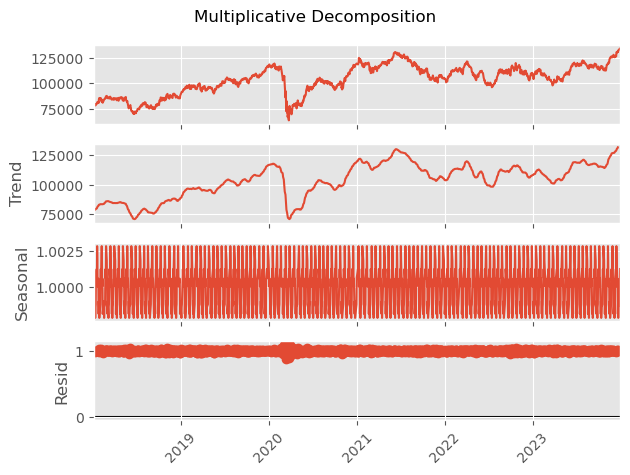

In [5]:
# Additive Decomposition

zo.seasonal_decomposition(model = 'multiplicative')

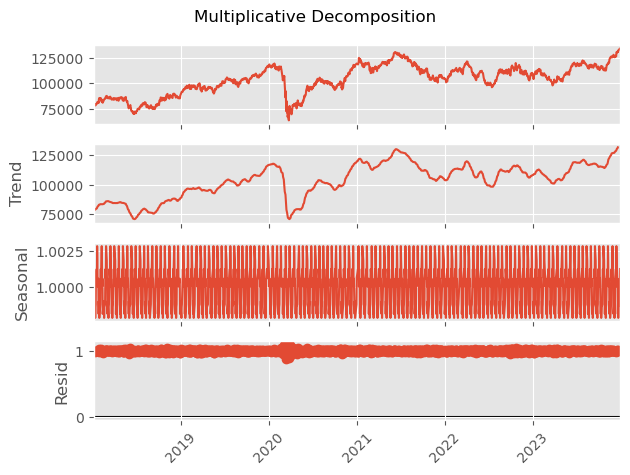

In [6]:
# Multiplicative Decomposition

zo.seasonal_decomposition(model = 'multiplicative')

- Trend

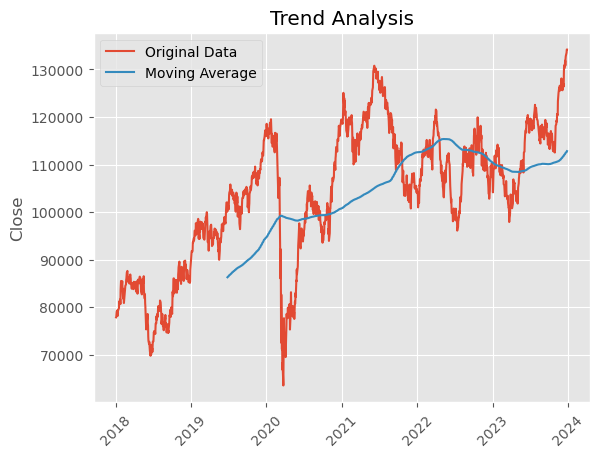

In [7]:
zo.trend(365)

- Periodogram

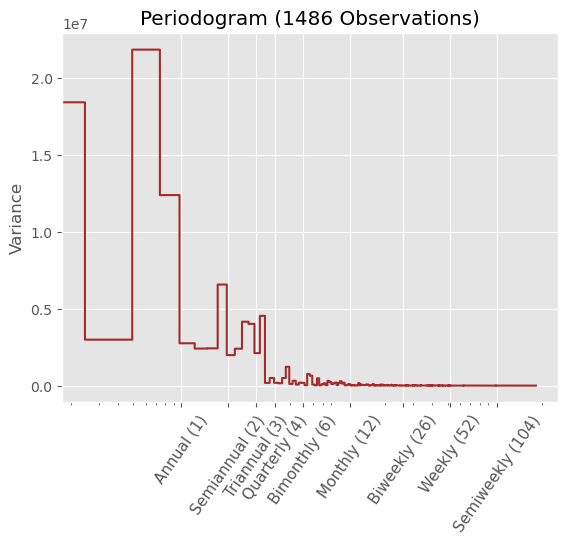

In [8]:
zo.periodogram()

- Seasonal Plots

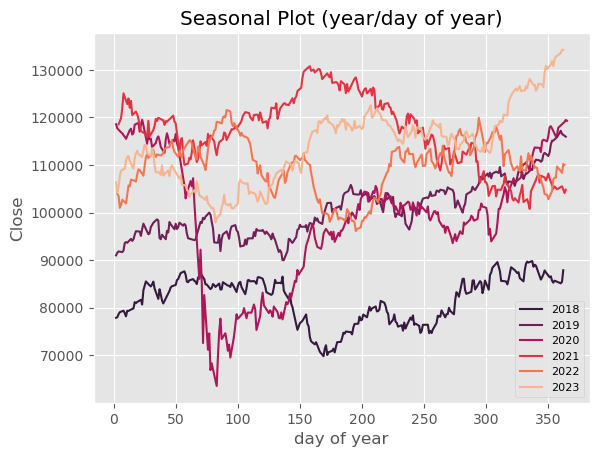

In [9]:
# Daily analysis

zo.seasonal_plots(period = 'year', freq = 'day of year')

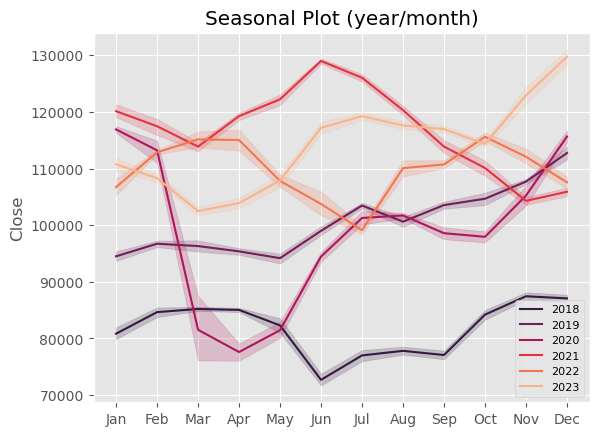

In [10]:
# Monthly analysis

zo.seasonal_plots('year', 'month', xlabel = 'hide')

- Lag Plots

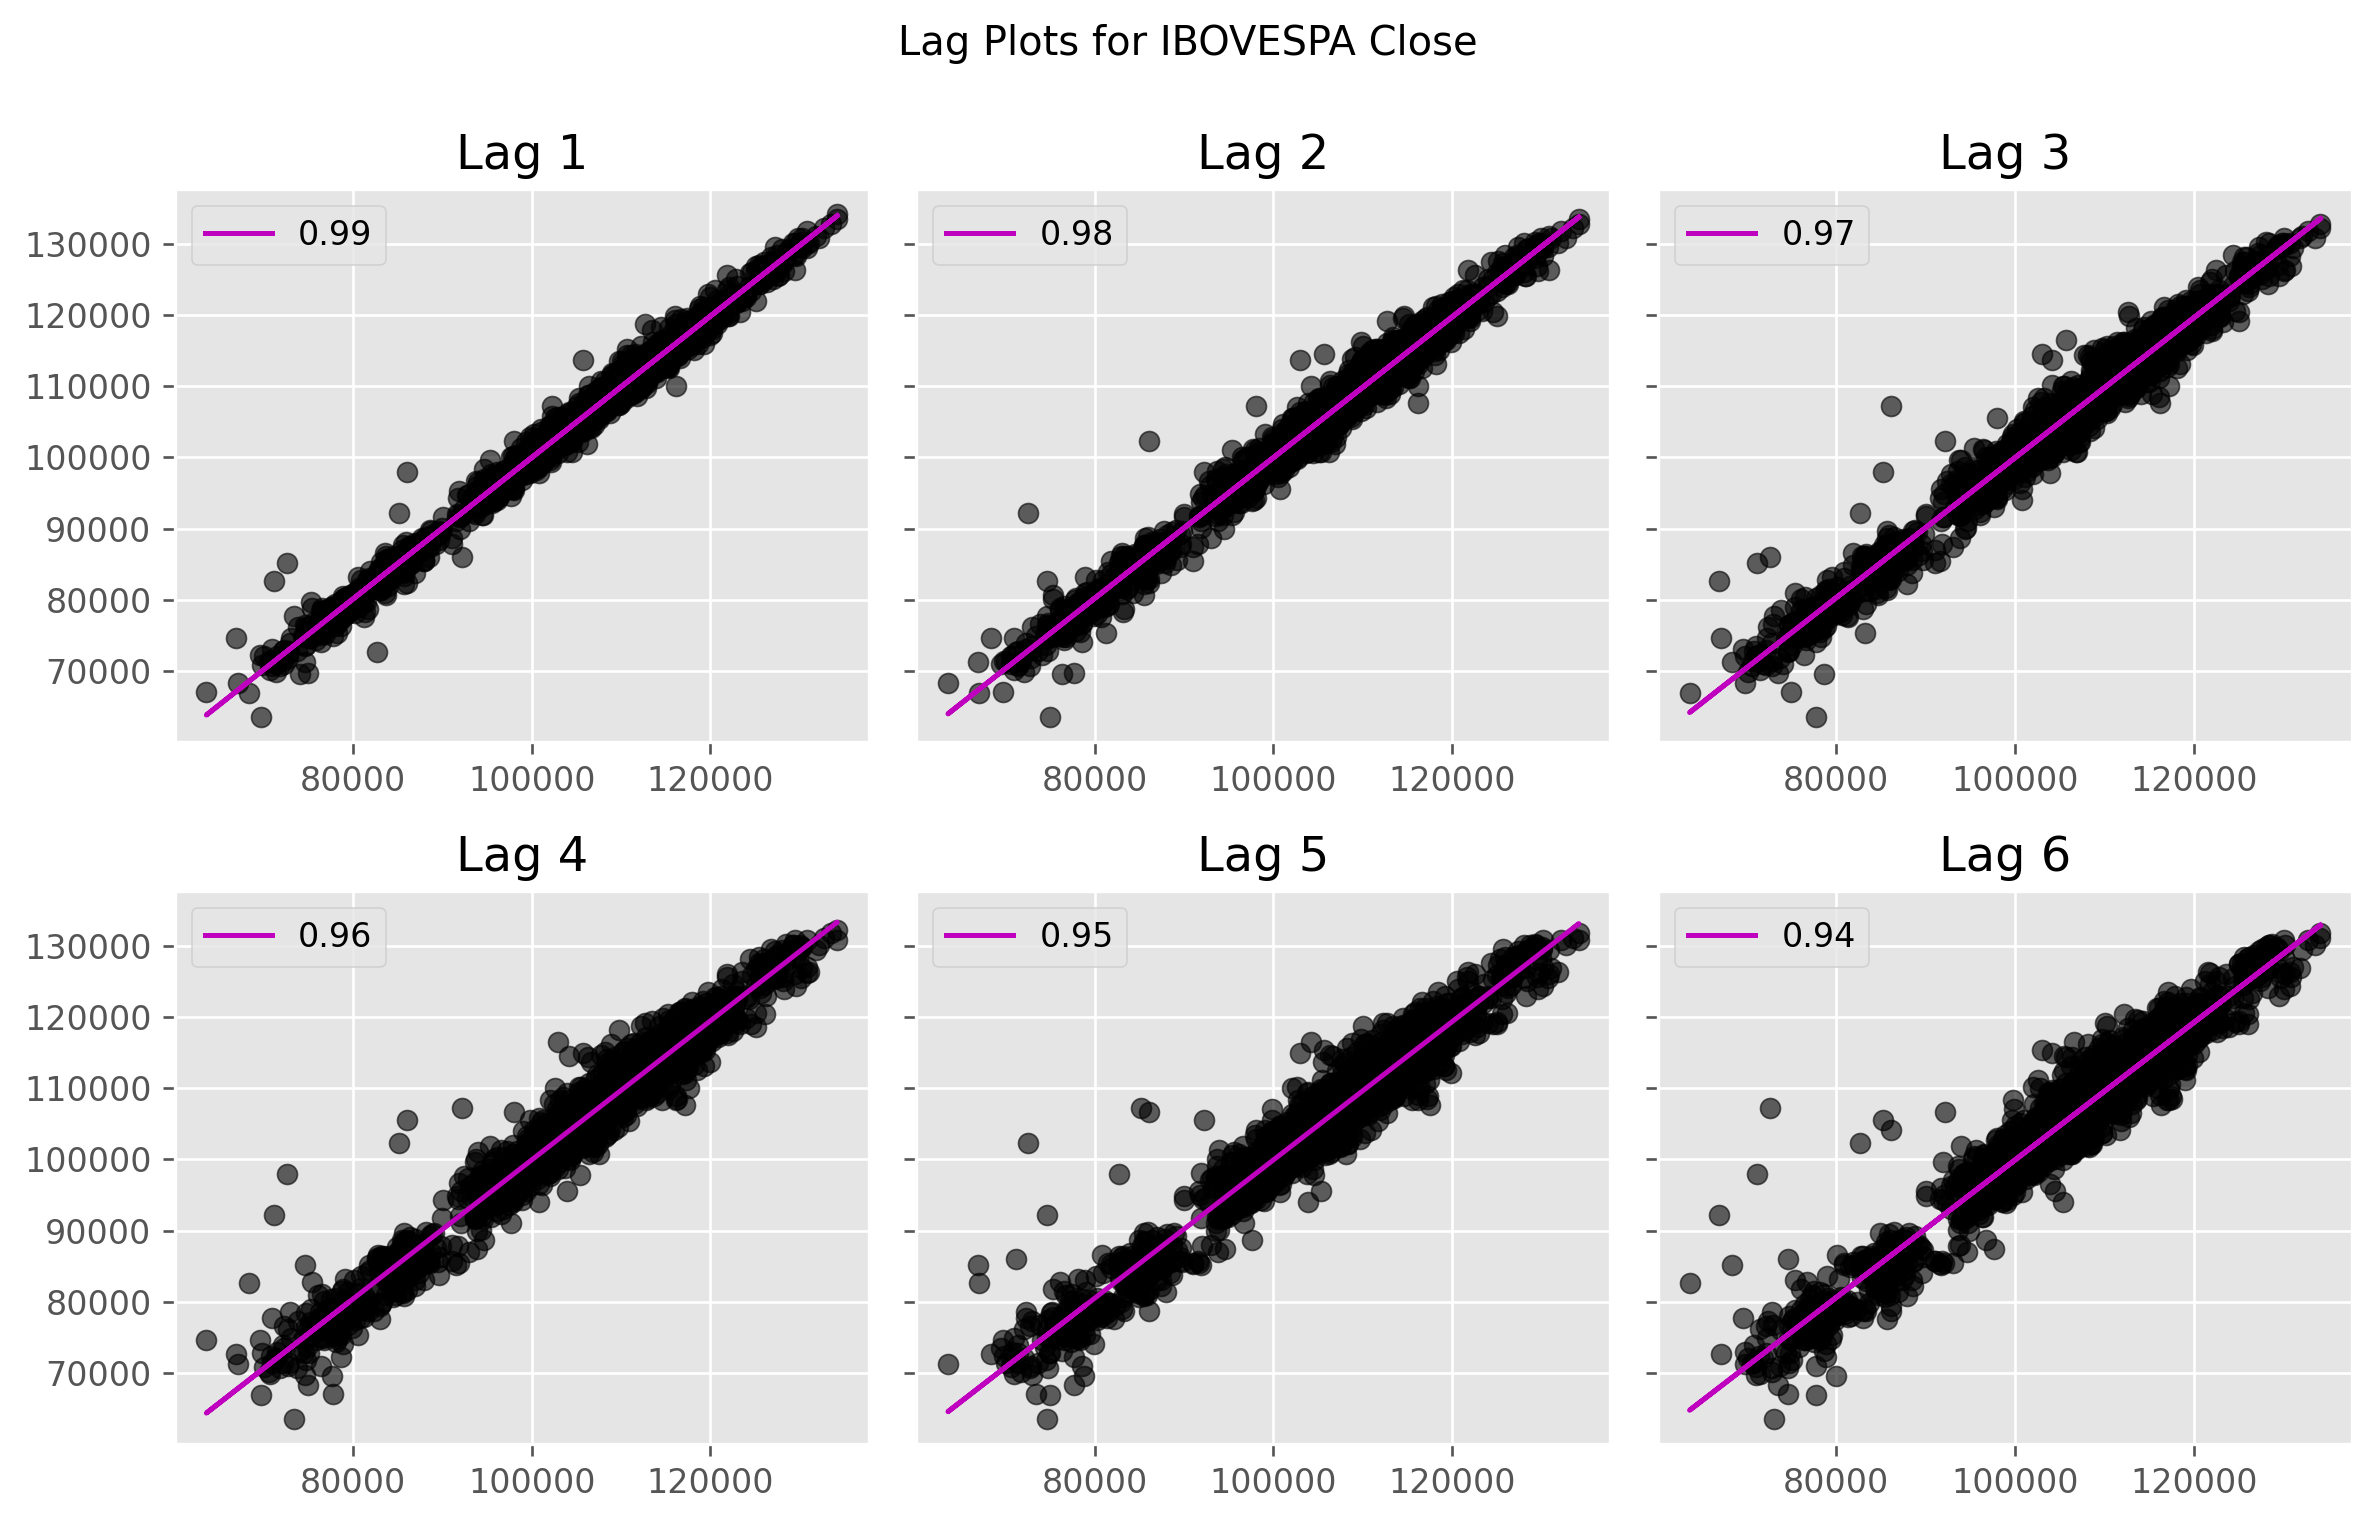

In [11]:
# Lag plots for six lags

zo.lags(6, 'Lag Plots for IBOVESPA Close')

- Augmented Dickey-Fuller Test

In [12]:
# Unit root test on original data

zo.adfuller_test()

This series is not stationary!

Results of Dickey-Fuller Test


,Scores
Test Statistic,-2.097404
p-value,0.245560
Lags Used,8.000000
Observations,1477.000000
Critical Value (1%),-3.434785
Critical Value (5%),-2.863499
Critical Value (10%),-2.567813


In [13]:
# Performing Augmented Dickey-Fuller Test on Zeit instance after Logarithmic transformation and differencing

log_data = np.log(zo.data)
diff_data = log_data.diff().dropna()
zt_diff = zp.Zeit(diff_data)
zt_diff.adfuller_test()

This series is stationary!

Results of Dickey-Fuller Test


,Scores
Test Statistic,-1.193742e+01
p-value,4.627291e-22
Lags Used,7.000000e+00
Observations,1.477000e+03
Critical Value (1%),-3.434785e+00
Critical Value (5%),-2.863499e+00
Critical Value (10%),-2.567813e+00


- Split Data

In [14]:
# Testing in an alternative dataset

retail_sales_path = 'datasets/retail_sales_us.csv'
df = pd.read_csv(retail_sales_path)
df.head()

,Date,Water_UnitSales,Alcohol_UnitSales
0,10/6/2019,166396556.0,150101757.0
1,10/13/2019,157116476.0,147027893.0
2,10/20/2019,150442968.0,145748467.0
3,10/27/2019,149196153.0,145996632.0
4,11/3/2019,144728816.0,146590953.0


In [15]:
# Logarithmic transformation, differencing and Augmented Dickey-Fuller Test on new dataset

zo = zp.Zeit(retail_sales_path, '%m/%d/%Y', 'Date', 'Alcohol_UnitSales')
log_data = np.log(zo.data)
diff_data = log_data.diff().dropna()
zo_diff = zp.Zeit(diff_data)
zo_diff.adfuller_test()

This series is stationary!

Results of Dickey-Fuller Test


,Scores
Test Statistic,-1.250978e+01
p-value,2.690310e-23
Lags Used,2.000000e+00
Observations,1.840000e+02
Critical Value (1%),-3.466398e+00
Critical Value (5%),-2.877380e+00
Critical Value (10%),-2.575214e+00


In [16]:
# Splitting data for forecasting

train, test = zo.split_data() # Original scale
train_diff, _ = zo_diff.split_data() # Zeit object data differenced in log scale
train_data, test_data = train.data, test.data
train_data.size, test_data.size

(150, 38)

- Correlogram

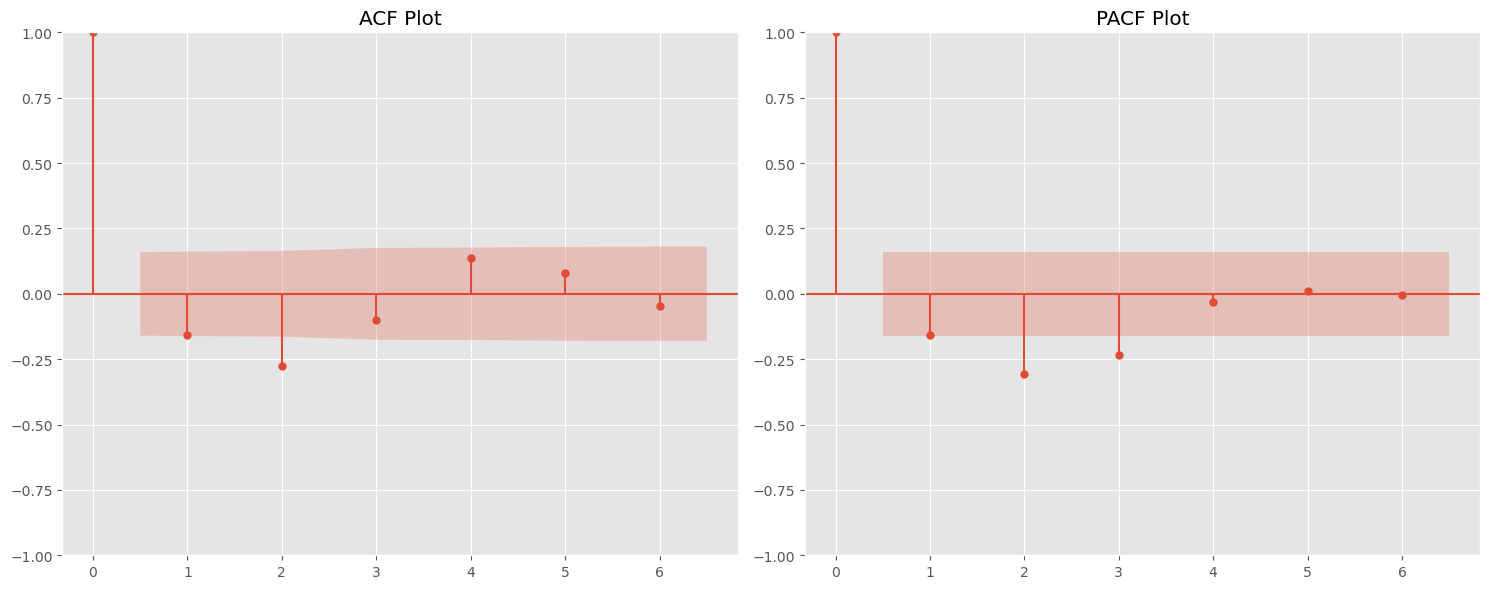

In [17]:
# Displaying correlograms

train_diff.correlogram()

- Evaluate

In [18]:
# Fitting the data with Exponential Smothing (TES) model

tes_model = ES(
    train_data, 
    trend = 'add', 
    damped_trend = True, 
    seasonal = 'add', 
    seasonal_periods = 52
).fit()

In [19]:
# Forecasting with TES for the next 'steps' weeks

steps = len(test_data)
tes_forecast = tes_model.forecast(steps)
forecast_models = [('TES', tes_forecast)]

In [20]:
# Comparison

zo.evaluate(forecast_models = forecast_models, test_data = test_data)

,2022-08-21,2022-08-28,2022-09-04,2022-09-11,2022-09-18,2022-09-25,2022-10-02,2022-10-09,2022-10-16,2022-10-23
Actual,1.557800e+08,1.557263e+08,1.654902e+08,1.545241e+08,1.538235e+08,1.544509e+08,1.513215e+08,1.515360e+08,1.506181e+08,1.474300e+08
TES,1.567287e+08,1.558970e+08,1.644032e+08,1.528659e+08,1.520253e+08,1.506519e+08,1.504586e+08,1.501845e+08,1.488980e+08,1.480109e+08


In [21]:
# Metrics

zo.evaluate(forecast_models = forecast_models, test_data = test_data, view = 'metrics')

,MSE,RMSE,MAE,MAPE
TES,3.197266e+13,5.654437e+06,4.155914e+06,0.028321


# END